Analyse de Données de Vente au Détail avec Neo4j
Ce notebook présente une analyse complète des données de vente au détail en utilisant Neo4j comme base de données graphe. 
### Objectifs:
 - Import et nettoyage des données
 - Création du graphe de relations
 - Analyse des clients, produits et transactions
 - Calcul de similarités entre clients
 - Système de recommandation 
### Structure:
 1. Connexion à Neo4j
 2. Nettoyage de la base (optionnel)
 3. Création des contraintes et index
 4. Import des données
 5. Agrégation des relations
 6. Analyses diverses
 7. Visualisations 

### Bloc 1: Installation des dépendances

In [4]:
!pip install neo4j pandas matplotlib seaborn numpy scikit-learn networkx python-louvain
!pip install graphdatascience

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=29733d801dfe2df6a8de2fc07694834a6c75901281a2dfdc5228ec672fa24250
  Stored in directory: c:\users\macky\appdata\local\pip\cache\wheels\ee\52\54\7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain

   ---------------------------------------- 0/2 [networkx]
   ---------------------------------------- 0/2 [networkx]
   ---------------------------------------- 0/2 [networkx]
   ---------------------------------------- 0/2 [n

### Bloc 2: Import des bibliothèques

In [5]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Bloc 3: Connexion à Neo4j

In [ ]:
class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
            
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

# Configuration de la connexion
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"  # Remplacez par votre mot de passe

# Initialisation de la connexion
conn = Neo4jConnection(uri=uri, user=username, pwd=password)

# Test de connexion
try:
    result = conn.query("RETURN 'Connexion réussie à Neo4j' AS message")
    print(result[0]['message'])
except Exception as e:
    print(f"Erreur de connexion: {e}")

Connexion réussie à Neo4j


### Bloc 4: Nettoyage de la base 

In [8]:
print("Nettoyage de la base de données...")
conn.query("MATCH (n) DETACH DELETE n")
print("Base de données nettoyée.")

Nettoyage de la base de données...
Base de données nettoyée.


### Bloc 5: Création des contraintes et index

In [9]:
print("Création des contraintes et index...")

constraints_queries = [
    "CREATE CONSTRAINT customer_id_unique IF NOT EXISTS FOR (c:Customer) REQUIRE c.id IS UNIQUE",
    "CREATE CONSTRAINT invoice_id_unique IF NOT EXISTS FOR (i:Invoice) REQUIRE i.id IS UNIQUE",
    "CREATE CONSTRAINT product_stockcode_unique IF NOT EXISTS FOR (p:Product) REQUIRE p.stockCode IS UNIQUE",
    "CREATE CONSTRAINT country_name_unique IF NOT EXISTS FOR (c:Country) REQUIRE c.name IS UNIQUE"
]

index_queries = [
    "CREATE INDEX customer_id_index IF NOT EXISTS FOR (c:Customer) ON (c.id)",
    "CREATE INDEX invoice_id_index IF NOT EXISTS FOR (i:Invoice) ON (i.id)",
    "CREATE INDEX product_stockcode_index IF NOT EXISTS FOR (p:Product) ON (p.stockCode)",
    "CREATE INDEX invoice_date_index IF NOT EXISTS FOR (i:Invoice) ON (i.date)",
    "CREATE INDEX contains_quantity_index IF NOT EXISTS FOR ()-[r:CONTAINS]-() ON (r.quantity)",
    "CREATE INDEX contains_price_index IF NOT EXISTS FOR ()-[r:CONTAINS]-() ON (r.price)"
]

for query in constraints_queries + index_queries:
    try:
        conn.query(query)
        print(f"Succès: {query[:50]}...")
    except Exception as e:
        print(f"Erreur avec {query[:50]}...: {e}")

print("Contraintes et index créés avec succès.")


Création des contraintes et index...
Succès: CREATE CONSTRAINT customer_id_unique IF NOT EXISTS...
Succès: CREATE CONSTRAINT invoice_id_unique IF NOT EXISTS ...
Succès: CREATE CONSTRAINT product_stockcode_unique IF NOT ...
Succès: CREATE CONSTRAINT country_name_unique IF NOT EXIST...
Succès: CREATE INDEX customer_id_index IF NOT EXISTS FOR (...
Succès: CREATE INDEX invoice_id_index IF NOT EXISTS FOR (i...
Succès: CREATE INDEX product_stockcode_index IF NOT EXISTS...
Succès: CREATE INDEX invoice_date_index IF NOT EXISTS FOR ...
Succès: CREATE INDEX contains_quantity_index IF NOT EXISTS...
Succès: CREATE INDEX contains_price_index IF NOT EXISTS FO...
Contraintes et index créés avec succès.


Les contraintes garantissent qu’il n’y a pas de doublons pour les clients, factures et produits 

Les index accélèrent fortement les opérations de recherche (MERGE, MATCH) : sans index, une recherche sur plusieurs lignes est très lente.

### Bloc 6: Import des données depuis le CSV

In [10]:
print("Début de l'import des données...")

import_query = """
LOAD CSV WITH HEADERS FROM 'file:///online_retail_II.csv' AS row
WITH row
WHERE row.`Customer ID` IS NOT NULL AND trim(row.`Customer ID`) <> ''
LIMIT 10000

WITH row,
     trim(row.`Customer ID`) AS custid_str,
     trim(row.Invoice) AS invoice_str,
     trim(row.Quantity) AS qty_str,
     trim(row.Price) AS price_str,
     trim(row.StockCode) AS stockcode_str,
     trim(row.Description) AS description_str,
     trim(row.Country) AS country_str,
     CASE WHEN row.InvoiceDate IS NOT NULL AND trim(row.InvoiceDate) <> '' 
          THEN replace(trim(row.InvoiceDate), ' ', 'T') 
          ELSE NULL END AS invoice_datetime_iso

WITH row,
     CASE WHEN custid_str <> '' THEN toInteger(toFloat(custid_str)) ELSE NULL END AS custid,
     CASE WHEN invoice_str <> '' THEN toInteger(toFloat(invoice_str)) ELSE NULL END AS invoice_id,
     CASE WHEN qty_str <> '' THEN toInteger(toFloat(qty_str)) ELSE 0 END AS qty,
     CASE WHEN price_str <> '' THEN toFloat(price_str) ELSE 0.0 END AS price,
     stockcode_str, description_str, country_str, invoice_datetime_iso

WHERE custid IS NOT NULL

MERGE (c:Customer {id: custid})
MERGE (co:Country {name: coalesce(country_str, 'Unknown')})
MERGE (c)-[:FROM_COUNTRY]->(co)
MERGE (p:Product {stockCode: coalesce(stockcode_str, 'UNKNOWN')})
ON CREATE SET p.description = coalesce(description_str, '')

FOREACH (_ IN CASE WHEN invoice_id IS NOT NULL THEN [1] ELSE [] END |
  MERGE (i:Invoice {id: invoice_id})
  ON CREATE SET i.date = CASE WHEN invoice_datetime_iso IS NOT NULL THEN datetime(invoice_datetime_iso) ELSE NULL END
  MERGE (c)-[:PLACED]->(i)
  CREATE (i)-[:CONTAINS {
      quantity: qty,
      price: price,
      isReturn: (qty < 0)
  }]->(p)
)
"""

try:
    result = conn.query(import_query)
    print("Import des données terminé avec succès!")
except Exception as e:
    print(f"Erreur lors de l'import: {e}")


Début de l'import des données...
Import des données terminé avec succès!


### Bloc 7: Vérification des données importées

In [11]:
print("Vérification des données importées...")

count_queries = {
    "Customers": "MATCH (c:Customer) RETURN count(c) AS count",
    "Invoices": "MATCH (i:Invoice) RETURN count(i) AS count",
    "Products": "MATCH (p:Product) RETURN count(p) AS count",
    "Countries": "MATCH (co:Country) RETURN count(co) AS count",
    "CONTAINS Relationships": "MATCH ()-[r:CONTAINS]->() RETURN count(r) AS count"
}

for label, query in count_queries.items():
    try:
        result = conn.query(query)
        print(f"{label}: {result[0]['count']}")
    except Exception as e:
        print(f"Erreur pour {label}: {e}")

Vérification des données importées...
Customers: 428
Invoices: 458
Products: 1997
Countries: 16
CONTAINS Relationships: 9801


on a 428 clients dans cet échantillon
458 factures (donc certains clients ont plusieurs factures) et 1997 produits référencés.

9801 lignes CONTAINS : on a beaucoup de lignes détail facture 
un même invoice peut contenir plusieurs produits, ce qui explique que CONTAINS >> Invoices.

### Bloc 8: Agrégation des relations CONTAINS en PURCHASED

In [13]:
print("Agrégation des relations CONTAINS en PURCHASED...")

aggregation_query = """
MATCH (c:Customer)-[:PLACED]->(i:Invoice)-[cont:CONTAINS]->(p:Product)
WHERE cont.quantity > 0
WITH c, p, sum(cont.quantity) AS total_quantity, 
     sum(cont.quantity * cont.price) AS total_amount, 
     count(i) AS transaction_count
MERGE (c)-[pur:PURCHASED]->(p)
SET pur.total_quantity = total_quantity,
    pur.total_amount = total_amount,
    pur.transaction_count = transaction_count,
    pur.avg_price = total_amount / total_quantity
"""

try:
    result = conn.query(aggregation_query)
    print("Agrégation des relations terminée avec succès!")
    
    # Vérification
    pur_count = conn.query("MATCH ()-[r:PURCHASED]->() RETURN count(r) AS count")[0]['count']
    print(f"Relations PURCHASED créées: {pur_count}")
except Exception as e:
    print(f"Erreur lors de l'agrégation: {e}")

Agrégation des relations CONTAINS en PURCHASED...
Agrégation des relations terminée avec succès!
Relations PURCHASED créées: 9291


Au lieu de considérer chaque achat individuellement, comme "Le client A a acheté le produit X hier", on regroupe tous les achats du client de cette manière : "Le client A a acheté 50 produits X pour un total de 1000 €

 sa nous permet de comprendre les comportements d'achat globaux

 Moins de données à traiter = analyses plus rapides

et identifier les gros acheteurs vs petits acheteurs

### Bloc 9: Analyse des données de base

In [14]:
print("Analyse des données de base...")

# Fonction pour exécuter des requêtes et retourner un DataFrame
def run_query_to_df(query, parameters=None):
    result = conn.query(query, parameters)
    if result:
        return pd.DataFrame([dict(record) for record in result])
    return pd.DataFrame()

# 9.1: Top 10 des pays par nombre de clients
country_stats = run_query_to_df("""
MATCH (c:Customer)-[:FROM_COUNTRY]->(co:Country)
RETURN co.name AS country, count(c) AS customer_count
ORDER BY customer_count DESC
LIMIT 10
""")

print("Top 10 des pays par nombre de clients:")
print(country_stats)


Analyse des données de base...
Top 10 des pays par nombre de clients:
          country  customer_count
0  United Kingdom             397
1          France              10
2         Germany               4
3            EIRE               2
4           Spain               2
5         Belgium               2
6     Netherlands               2
7             USA               1
8         Denmark               1
9       Australia               1


l'échantillon est fortement concentré au Royaume-Uni (397/428 clients) pour les autres pays ces très minoritaires

### 9.2: Top 10 des produits par revenu

In [15]:
product_stats = run_query_to_df("""
MATCH (c:Customer)-[p:PURCHASED]->(prod:Product)
RETURN 
    prod.stockCode AS product_code,
    prod.description AS product_description,
    sum(p.total_quantity) AS total_quantity,
    sum(p.total_amount) AS total_revenue,
    count(DISTINCT c) AS customer_count
ORDER BY total_revenue DESC
LIMIT 10
""")

print("Top 10 des produits par revenu:")
print(product_stats)

Top 10 des produits par revenu:
  product_code                  product_description  total_quantity  \
0        22086       PAPER CHAIN KIT 50'S CHRISTMAS            1861   
1       85123A   WHITE HANGING HEART T-LIGHT HOLDER            1648   
2        84347  ROTATING SILVER ANGELS T-LIGHT HLDR            1828   
3      15056BL              EDWARDIAN PARASOL BLACK            1003   
4        84879        ASSORTED COLOUR BIRD ORNAMENT            1985   
5        20679                EDWARDIAN PARASOL RED             831   
6       85014B      RED/WHITE DOTS RUFFLED UMBRELLA             722   
7       79323W                  WHITE CHERRY LIGHTS             399   
8       15056N            EDWARDIAN PARASOL NATURAL             690   
9       85014A     BLACK/BLUE DOTS RUFFLED UMBRELLA             658   

   total_revenue  customer_count  
0        4687.25              60  
1        4369.60              67  
2        3959.40              20  
3        3777.85              13  
4        30

Ce sont les produits qui rapportent le plus (quantité × prix). 
Certains produits une quantité élevée qui rapport beaucoup au chiffre.
ces produits devraient être approvisionnés en priorité

PAPER CHAIN KIT: 4,687€ (60 clients)

T-LIGHT HOLDER: 4,370€ (67 clients)

ANGELS T-LIGHT: 3,959€ (20 clients)

### 9.3: Top 10 des clients par valeur

In [16]:
customer_stats = run_query_to_df("""
MATCH (c:Customer)-[p:PURCHASED]->(prod:Product)
RETURN 
    c.id AS customer_id,
    sum(p.total_amount) AS total_spent,
    sum(p.total_quantity) AS total_quantity,
    count(DISTINCT prod) AS distinct_products
ORDER BY total_spent DESC
LIMIT 10
""")

print("Top 10 des clients par valeur:")
print(customer_stats)

Top 10 des clients par valeur:
   customer_id  total_spent  total_quantity  distinct_products
0        18102     20761.24            7651                 30
1        13777      6394.82            2866                 23
2        15061      6256.74            3222                 19
3        14646      5711.04            3792                 22
4        17949      4619.16            2738                  6
5        17940      4380.00           17520                  4
6        17511      3108.64            2020                 30
7        17850      2715.84             806                 18
8        13694      2529.89            2247                 13
9        14031      2506.14            1132                 61


On identifie qui sont nos meilleurs clients et quels produits se vendent le mieux
Top Client: ID 18102 → 20761€ dépensés
client 13777: total_spent 6394.82

client 15061: total_spent 6256.74

l'entreprise pourais utiliser leurs historiques pour recommandations personnalisées des clients fidèle

### Bloc 10: Visualisations des analyses de base

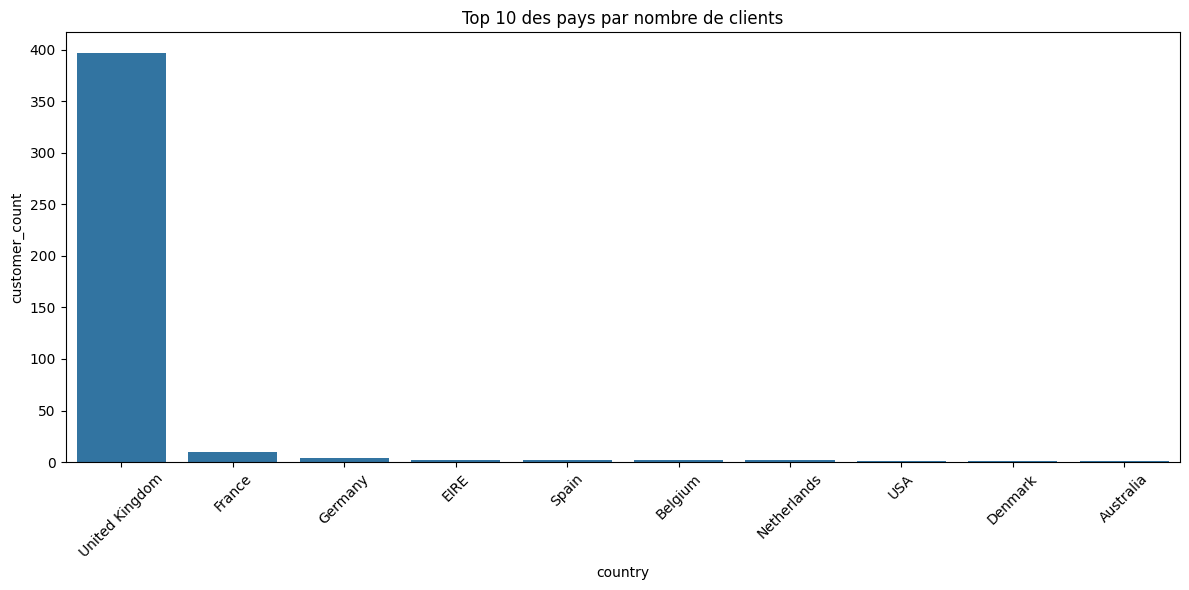

In [40]:
# 10.1: Visualisation des top pays
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='customer_count', data=country_stats)
plt.title('Top 10 des pays par nombre de clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce graphique montre d'où viennent les clients 

Le Royaume-Uni domine totalement : 397 clients sur 428
C'est 93% de tous les clients

La France est 2ème... mais très loin derrière

### 10.2: Visualisation des top produits

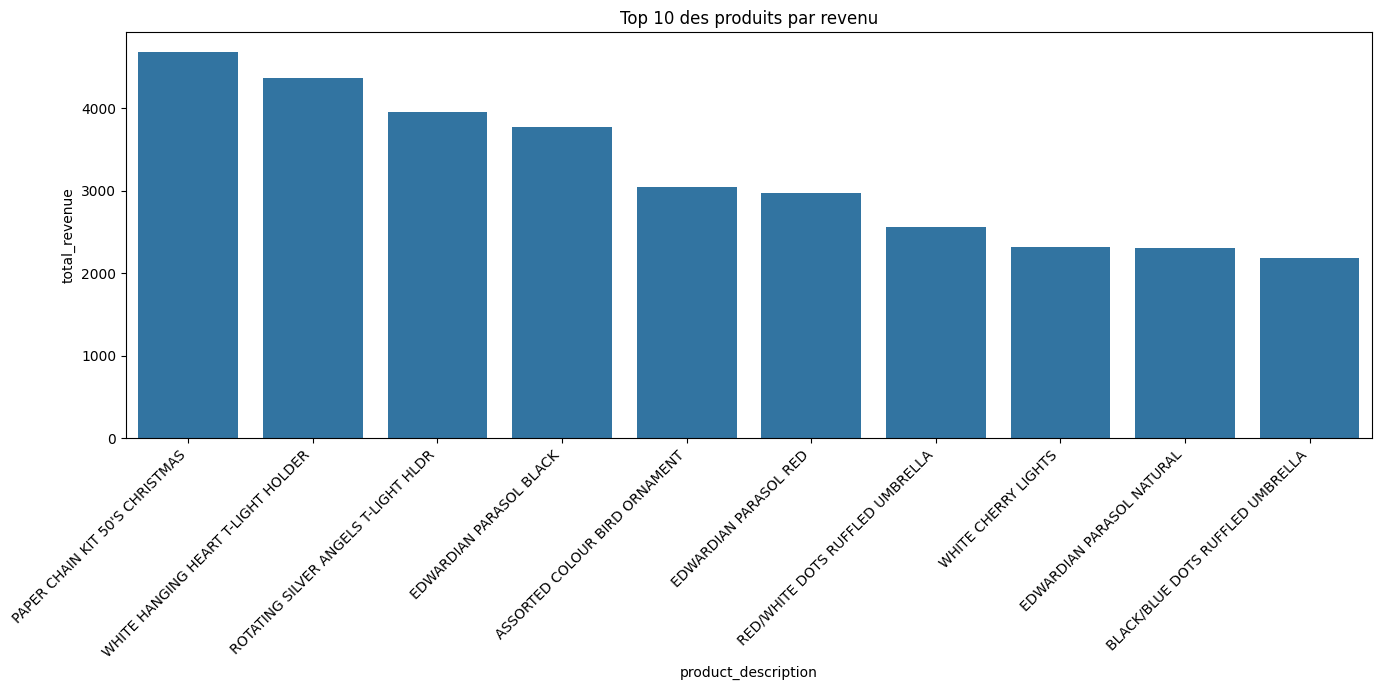

In [18]:
plt.figure(figsize=(14, 7))
sns.barplot(x='product_description', y='total_revenue', data=product_stats)
plt.title('Top 10 des produits par revenu')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Ce graphique montre ce qui rapporte le plus d'argent dans l'entreprise

Le PAPER CHAIN KIT est le meilleur vendeur environ 4,700€ de revenus !

ces produit doivent être prioritaires pour l’approvisionnement et la négociation des fournisseurs

### 10.3: Visualisation des top clients

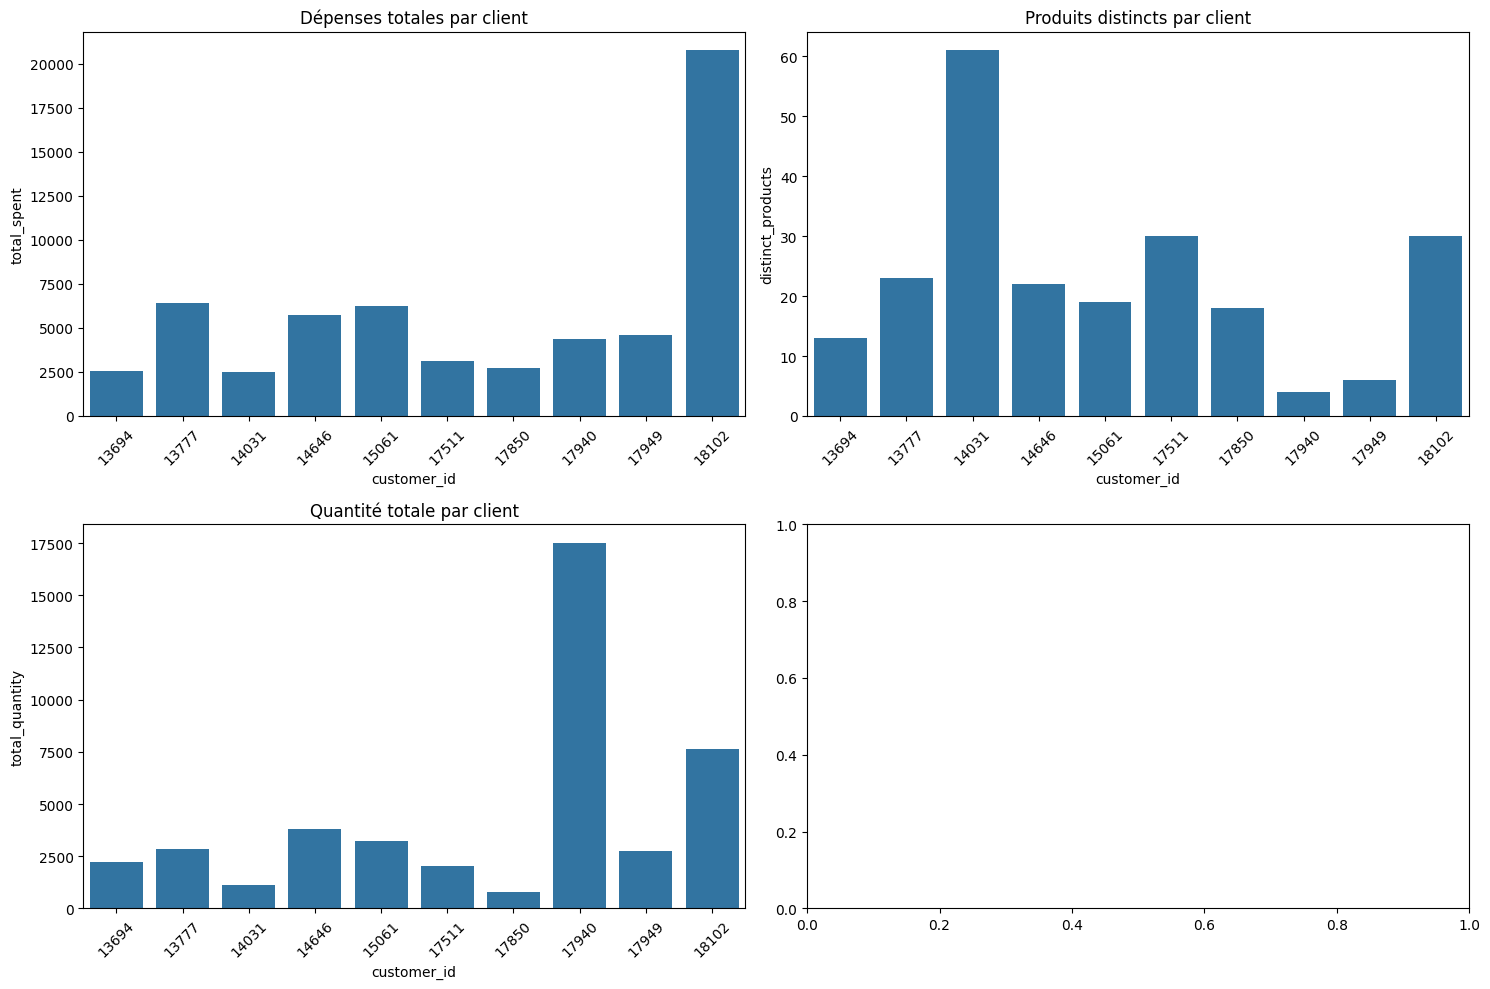

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(x='customer_id', y='total_spent', data=customer_stats, ax=axes[0, 0])
axes[0, 0].set_title('Dépenses totales par client')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(x='customer_id', y='distinct_products', data=customer_stats, ax=axes[0, 1])
axes[0, 1].set_title('Produits distincts par client')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(x='customer_id', y='total_quantity', data=customer_stats, ax=axes[1, 0])
axes[1, 0].set_title('Quantité totale par client')
axes[1, 0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Bloc 12: Analyse des associations de produits

In [ ]:
print("Analyse des produits fréquemment achetés ensemble...")

product_associations = run_query_to_df("""
MATCH (i:Invoice)-[:CONTAINS]->(p1:Product)
MATCH (i:Invoice)-[:CONTAINS]->(p2:Product)
WHERE p1.stockCode < p2.stockCode AND id(p1) <> id(p2)
RETURN 
    p1.stockCode AS product1_code,
    p1.description AS product1_desc,
    p2.stockCode AS product2_code,
    p2.description AS product2_desc,
    count(i) AS co_occurrence_count
ORDER BY co_occurrence_count DESC
LIMIT 15
""")

print("Top 15 des associations de produits:")
print(product_associations)

Analyse des produits fréquemment achetés ensemble...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function. ('id' has been replaced by 'elementId or consider using an application-generated id')} {position: line: 4, column: 39, offset: 127} for query: '\nMATCH (i:Invoice)-[:CONTAINS]->(p1:Product)\nMATCH (i:Invoice)-[:CONTAINS]->(p2:Product)\nWHERE p1.stockCode < p2.stockCode AND id(p1) <> id(p2)\nRETURN \n    p1.stockCode AS product1_code,\n    p1.description AS product1_desc,\n    p2.stockCode AS product2_code,\n    p2.description AS product2_desc,\n    count(i) AS co_occurrence_count\nORDER BY co_occurrence_count DESC\nLIMIT 15\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated an

Top 15 des associations de produits:
   product1_code                      product1_desc product2_code  \
0          21231     SWEETHEART CERAMIC TRINKET BOX         21232   
1          22138       BAKING SET 9 PIECE RETROSPOT         22139   
2          21790                 VINTAGE SNAP CARDS         21791   
3          21733   RED HANGING HEART T-LIGHT HOLDER        85123A   
4         79323P                 PINK CHERRY LIGHTS        79323W   
5          82482  WOODEN PICTURE FRAME WHITE FINISH        82494L   
6         85014A   BLACK/BLUE DOTS RUFFLED UMBRELLA        85014B   
7          21490       SET OF THREE 50'S GIFT WRAPS         21491   
8          21491    SET OF THREE VINTAGE GIFT WRAPS         21791   
9          22083         PAPER CHAIN KIT RETRO SPOT         22086   
10         21791  VINTAGE HEADS AND TAILS CARD GAME         22142   
11         21929     JUMBO BAG PINK VINTAGE PAISLEY        85099B   
12        79323W                WHITE CHERRY LIGHTS        85123A 

nous identifions les produits fréquemment achetés ensemble dans le même panier d'achat

Top 1:
SWEETHEART BOX + STRAWBERRY BOX (35 fois ensemble)

Paires fréquemment achetées ensemble parfais pour les offres packagées

### Visualisation des associations

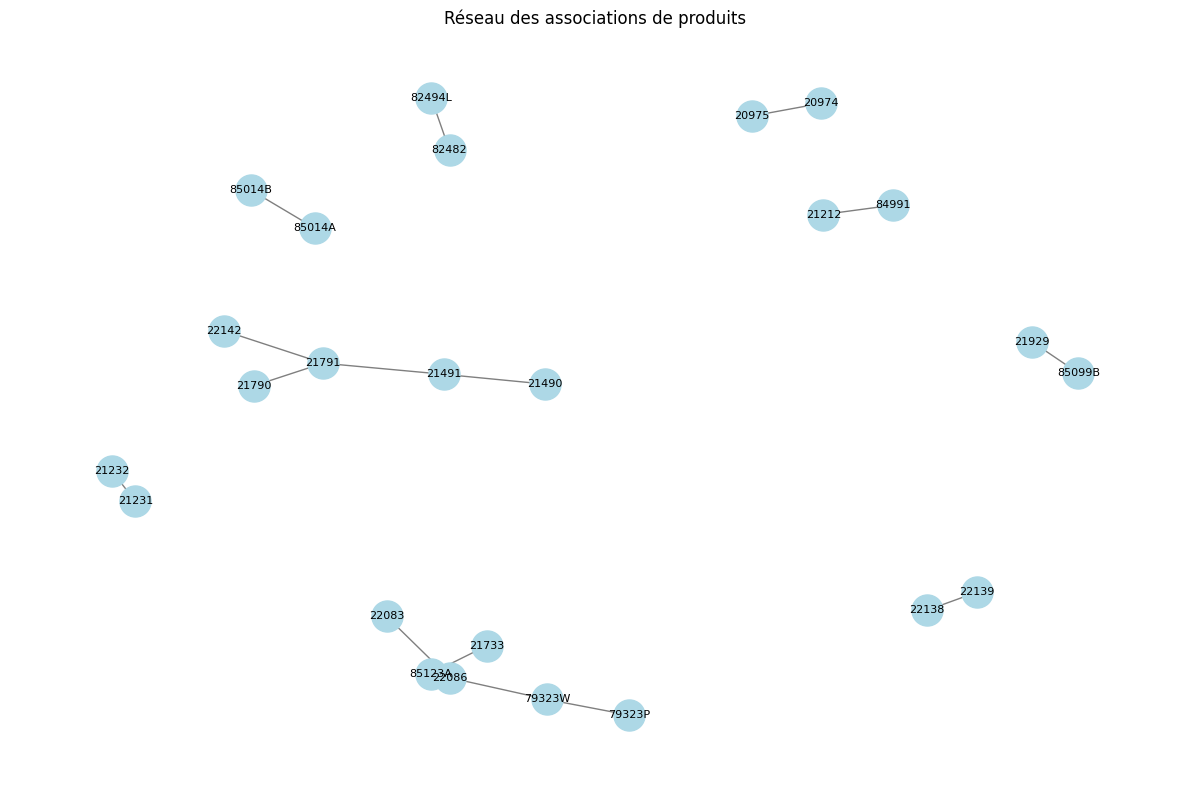

In [23]:
G = nx.Graph()

for _, row in product_associations.iterrows():
    G.add_node(row['product1_code'], desc=row['product1_desc'])
    G.add_node(row['product2_code'], desc=row['product2_desc'])
    G.add_edge(row['product1_code'], row['product2_code'], weight=row['co_occurrence_count'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Réseau des associations de produits')
plt.axis('off')
plt.tight_layout()
plt.show()

🔵 Nœuds (cercles): Représentent les produits (chaque cercle = un produit)

➖ Arêtes (lignes): Relient les produits achetés ensemble

Les produits connectés par des lignes sont naturellement associés dans l'esprit des clients. 

Exemple:

SWEETHEART BOX + STRAWBERRY BOX 

on peut créer des coffrets cadeaux regroupant ces produits

### Bloc 14: Calcul de similarité entre clients (approche manuelle)

Calcul de similarité entre clients...

### 14.1: Création d'une matrice client-produit

In [ ]:
client_product_matrix = run_query_to_df("""
MATCH (c:Customer)-[p:PURCHASED]->(prod:Product)
RETURN 
    c.id AS customer_id,
    prod.stockCode AS product_id,
    p.total_amount AS purchase_amount
""")

# Transformation en matrice pivot
pivot_matrix = client_product_matrix.pivot_table(
    index='customer_id', 
    columns='product_id', 
    values='purchase_amount', 
    fill_value=0
)

print(f"Matrice client-produit créée: {pivot_matrix.shape}")


Matrice client-produit créée: (385, 1987)


385 clients pour 1987 produits 
on a beaucoup plus de produits que de clients.

Donc :

La matrice est très creuse .

Ça illustre que chaque client ne consomme qu’un petit sous-ensemble de tout le catalogue.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(pivot_matrix)

# Création d'un DataFrame de similarités
similarity_df = pd.DataFrame(
    cosine_sim,
    index=pivot_matrix.index,
    columns=pivot_matrix.index
)

print("Matrice de similarité calculée:")
print(similarity_df.head())

Matrice de similarité calculée:
customer_id     12359     12362     12417  12435     12437     12490  \
customer_id                                                            
12359        1.000000  0.000000  0.032553    0.0  0.023178  0.005648   
12362        0.000000  1.000000  0.388642    0.0  0.428583  0.386345   
12417        0.032553  0.388642  1.000000    0.0  0.194557  0.174931   
12435        0.000000  0.000000  0.000000    1.0  0.000000  0.000000   
12437        0.023178  0.428583  0.194557    0.0  1.000000  0.282013   

customer_id     12510     12533     12577     12583  ...     18071     18087  \
customer_id                                          ...                       
12359        0.000000  0.030090  0.000000  0.035956  ...  0.016765  0.000000   
12362        0.787773  0.615311  0.000000  0.369937  ...  0.000000  0.000000   
12417        0.306161  0.293778  0.024937  0.155371  ...  0.037602  0.000000   
12435        0.000000  0.000000  0.000000  0.000000  ...  0.000

Après avoir construit la matrice client-produit, nous avons calculé une matrice de similarité entre clients grâce à la mesure du cosinus.

Chaque valeur mesure à quel point deux clients ont un comportement d’achat proche (1 = identique, 0 = totalement différent).

On observe que certains clients, comme les ID 12362 et 12510, ont une similarité très élevée (~0,78), ce qui indique qu’ils achètent pratiquement les mêmes produits.

À l’inverse, beaucoup de couples de clients ont une similarité nulle, ce qui est normal car la plupart des clients n’ont aucun produit en commun (matrice creuse).

Cela permet de repérer des groupes de clients aux comportements similaires.

Ces groupes peuvent servir à :

proposer des recommandations de produits (“les clients qui vous ressemblent ont acheté…”),

cibler des campagnes marketing adaptées,

### 14.3: Stockage des similarités dans Neo4j

In [27]:
# Préparation des données pour l'insertion
similarity_records = []
for i, cust1 in enumerate(pivot_matrix.index):
    for j, cust2 in enumerate(pivot_matrix.index):
        if i < j and cosine_sim[i, j] > 0.1:  # Seuil de similarité
            similarity_records.append({
                'cust1': int(cust1),
                'cust2': int(cust2),
                'similarity': float(cosine_sim[i, j])
            })

# Insertion par lots
batch_size = 100
for i in range(0, len(similarity_records), batch_size):
    batch = similarity_records[i:i + batch_size]
    query = """
    UNWIND $batch AS record
    MATCH (c1:Customer {id: record.cust1})
    MATCH (c2:Customer {id: record.cust2})
    MERGE (c1)-[s:SIMILAR_TO]-(c2)
    SET s.similarityScore = record.similarity,
        s.calculationDate = date()
    """
    conn.query(query, {'batch': batch})

print(f"{len(similarity_records)} relations de similarité créées.")


5854 relations de similarité créées.


Dans un premier temps, on a construit une matrice client-produit qui représente, pour chaque client, les montants dépensés par produit.

Ensuite, calculé la similarité cosinus entre tous les clients.
donc deux clients sont considérés comme similaires si leurs profils d’achats se ressemblent (même produits achetés, mêmes montants).

Comme le graphe peut contenir beaucoup de relations, on a défini un seuil de 0,1 : seules les paires de clients ayant une similarité significative sont retenues.

on avais 385 clients.

Après filtrage, on obtient 5 854 relations de similarité.

Cela montre que la majorité des clients sont assez différents, mais on retrouve quand même plusieurs groupes de clients proches dans leurs comportements d’achat.

### Bloc 15: Analyse des similarités

In [28]:
print("Analyse des relations de similarité...")

similarity_stats = run_query_to_df("""
MATCH (c1:Customer)-[s:SIMILAR_TO]-(c2:Customer)
RETURN 
    count(s) AS total_relationships,
    avg(s.similarityScore) AS avg_similarity,
    max(s.similarityScore) AS max_similarity,
    min(s.similarityScore) AS min_similarity
""")

print("Statistiques des similarités:")
print(similarity_stats)

Analyse des relations de similarité...
Statistiques des similarités:
   total_relationships  avg_similarity  max_similarity  min_similarity
0                11708        0.191752             1.0        0.100011


Similarité moyenne ≈ 0,19
 En moyenne, les clients partagent environ 19 % de similarité dans leurs achats.
 Cela montre que la base est hétérogène : beaucoup de clients sont assez différents, mais il existe tout de même des zones de convergence.

Similarité maximale = 1,0
 Deux clients ont exactement le même profil d’achat (mêmes produits, mêmes montants).
 Ce sont probablement des cas intéressants à analyser : doublons, ou clients avec un comportement quasi identique.

### Bloc 16: Système de recommandation

In [52]:
print("Implémentation du système de recommandation...")
def recommend_products(customer_id, top_n=5):
    """Recommander des produits basés sur les clients similaires"""
    query = """
    MATCH (c:Customer {id: $customer_id})-[s:SIMILAR_TO]-(similar:Customer)
    WITH similar, s.similarityScore AS similarity
    MATCH (similar)-[p:PURCHASED]->(rec:Product)
    WHERE NOT EXISTS((:Customer {id: $customer_id})-[:PURCHASED]->(rec))
    RETURN 
        rec.stockCode AS product_code,
        rec.description AS product_description,
        sum(similarity) AS recommendation_score,
        count(DISTINCT similar) AS similar_customers_count,
        avg(p.total_amount) AS average_price
    ORDER BY recommendation_score DESC
    LIMIT $top_n
    """
    return run_query_to_df(query, {'customer_id': customer_id, 'top_n': top_n})


# Test avec un client existant
test_customer = customer_stats.iloc[0]['customer_id']
recommendations = recommend_products(test_customer)

print(f"Recommandations pour le client {test_customer}:")
print(recommendations)

Implémentation du système de recommandation...
Recommandations pour le client 18102.0:
  product_code                 product_description  recommendation_score  \
0       85123A  WHITE HANGING HEART T-LIGHT HOLDER              1.367182   
1       79323P                  PINK CHERRY LIGHTS              1.312558   
2       79323W                 WHITE CHERRY LIGHTS              1.265193   
3        22086      PAPER CHAIN KIT 50'S CHRISTMAS              1.005704   
4       82494L          WOODEN FRAME ANTIQUE WHITE              0.936898   

   similar_customers_count  average_price  
0                        6     129.283333  
1                        5      62.810000  
2                        5      66.860000  
3                        4      60.162500  
4                        4      52.125000  


Nous avons testé notre système de recommandation sur un client donné (ID 18102).

Le principe est le suivant :

On identifie les clients similaires à ce client à l’aide des scores de similarité calculés précédemment.

On récupère les produits achetés par ces clients similaires, mais que le client testé n’a pas encore achetés.

Chaque produit est classé selon un score de recommandation, calculé en fonction :

du niveau de similarité avec les clients qui l’ont acheté,

du nombre de clients similaires qui ont acheté ce produit,

et du prix moyen auquel ce produit a été acheté (utile pour analyser l’accessibilité du produit).

Analyse

Le produit le plus recommandé pour ce client est WHITE HANGING HEART T-LIGHT HOLDER, car 6 clients similaires l’ont acheté et il cumule le score de similarité le plus élevé (1.36).

Les produits PINK CHERRY LIGHTS et WHITE CHERRY LIGHTS apparaissent aussi en tête, recommandés par plusieurs clients similaires.

La colonne average_price donne une indication sur la valeur moyenne des transactions de ce produit, ce qui permettrait d’adapter la recommandation au budget du client.

### Bloc 17: Export des données pour reporting

In [31]:
print("Export des données pour reporting...")

# Données clients complètes
customer_export = run_query_to_df("""
MATCH (c:Customer)-[:FROM_COUNTRY]->(co:Country)
OPTIONAL MATCH (c)-[s:SIMILAR_TO]-(other:Customer)
WITH c, co, count(DISTINCT other) AS similarity_count, avg(s.similarityScore) AS avg_similarity
OPTIONAL MATCH (c)-[p:PURCHASED]->(prod:Product)
RETURN 
    c.id AS customer_id,
    co.name AS country,
    similarity_count,
    avg_similarity,
    count(DISTINCT prod) AS products_purchased,
    sum(p.total_amount) AS total_spent,
    sum(p.total_quantity) AS total_quantity
ORDER BY total_spent DESC
""")

customer_export.to_csv('customer_analysis_export.csv', index=False)
print(f"Export clients: {len(customer_export)} lignes")

# Données produits
product_export = run_query_to_df("""
MATCH (p:Product)
OPTIONAL MATCH (c:Customer)-[pur:PURCHASED]->(p)
WITH 
    p,
    count(DISTINCT c) AS customer_count,
    sum(pur.total_quantity) AS total_quantity,
    sum(pur.total_amount) AS total_revenue,
    avg(pur.avg_price) AS avg_price
RETURN 
    p.stockCode AS product_code,
    p.description AS product_description,
    customer_count,
    total_quantity,
    total_revenue,
    avg_price
ORDER BY total_revenue DESC
""")

product_export.to_csv('product_analysis_export.csv', index=False)
print(f"Export produits: {len(product_export)} lignes")

Export des données pour reporting...
Export clients: 428 lignes
Export produits: 1997 lignes


Export des données pour reporting

Nous avons généré deux exports afin d’avoir une vue globale côté client et côté produit.

1. Export clients (428 lignes)

Chaque client est enrichi avec :

Pays d’origine (via la relation FROM_COUNTRY),

Nombre de clients similaires (combien d’autres clients sont reliés via une relation SIMILAR_TO),

Score moyen de similarité,

Nombre de produits achetés (produits distincts),

Montant total dépensé,

Quantité totale achetée.

1. 1. Cela permet d’identifier :

les meilleurs clients en termes de chiffre d’affaires,

les profils d’achat (gros acheteurs, clients très connectés à d’autres via la similarité, etc.),

la segmentation par pays pour voir où se trouvent les clients les plus actifs.

2. Export produits (1997 lignes)

Chaque produit est enrichi avec :

Nombre de clients différents qui l’ont acheté,

Quantité totale vendue,

Revenu total généré,

Prix moyen (moyenne des transactions).

2. 1. Cela permet d’identifier :

les produits les plus rentables (fort revenu total),

les produits les plus populaires (achetés par beaucoup de clients),

les produits stratégiques (faible prix mais forte diffusion, ou inversement).

### Bloc 19: Fermeture de la connexion et conclusion

In [35]:
conn.close()